In [1]:
from functions import *

train_ft = pd.read_csv('pump_data/training_set_features.csv')
train_labels = pd.read_csv('pump_data/training_set_labels.csv')
xtrain, xtest, ytrain, ytest = train_test_split(train_ft, train_labels, random_state=17)
ytest = ytest['status_group']

# merge them for EDA purposes
df = xtrain.merge(ytrain, on='id')

# a numeric version of our target
df['status_group_numeric'] = df['status_group'].map(lambda x: 1 if x == 'functional' else -1 if x == 'non functional' else 0)

# filling in null values
df['funder'] = df['funder'].fillna(value='unknown', axis=0)
df['public_meeting'] = df['public_meeting'].fillna(value='unknown', axis=0)
df['scheme_management'] = df['scheme_management'].fillna(value='unknown', axis=0)

## Building a Model

After looking through the rest of the data as well and cleaning things up, we landed on the following set of features.

In [2]:
features = ['amount_tsh', 'public_meeting', 'gps_height', 'longitude', 'latitude', 'basin', 'district_code', 'permit', 'extraction_type_class', 'payment', 'quality_group', 'quantity', 'waterpoint_type_group','region', 'construction_year']

categorical_features = ['quantity', 'public_meeting', 'basin', 'district_code', 'permit', 'extraction_type_class', 'payment', 'quality_group', 'waterpoint_type_group', 'region', 'construction_year']

numerical_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude']

# drop some outliers or small percentage placeholders
to_drop = [df.loc[df['amount_tsh'] > 40005].index, df.loc[df['longitude'] == 0].index, df.loc[df['district_code'] == 0].index]
for i in to_drop:
    df = df.drop(i)

xtrain_ft = df[features]
ytrain = df['status_group']


Each of these features seemed to have a decent correlation with a well's functionality. Other features were excluded for being redundant (there were three separate columns each related to extraction methods) or for having too much noise (there were several hundred different subvillages). 

Our next step was to decide what kind of model to use, as well as what kind of metric to use in scoring. The terms of the competition specify accuracy as the metric, so that decision was more or less made for us. The decision regarding the kind of model to use was a little trickier.

A few options could be ruled out easily. We couldn't use Naive Bayes, for example, because our features were not independent. Similarly, a logistic regression model would be difficult to justify because there would be severe multicollinearity among our features. This left a number of other options, but after a bit of trial and error it seemed that Random Forests would be the most promising. That said, the final goal would be to combine different model types to build an ensemble model.

Our initial Random Forest model can be found below.

In [3]:
# this pipeline works on our Cleaner task, which automates many of the cleaning steps described above, and gets dummies for categorical variables
forest_pipeline = Pipeline(steps=[
    ('cleaner', Cleaner()),
    ('randforest', RandomForestClassifier(),)
])

forest_pipeline.fit(xtrain_ft, ytrain)


forest_pipeline.score(xtest[features], ytest)

0.7885521885521886

78.7% accuracy for an untuned first pass seemed promising, especially as the winning score for the competition is 82%. Let's take a look at a confusion matrix.

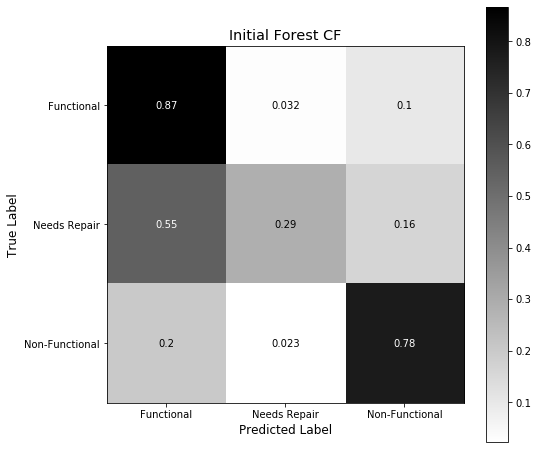

In [8]:
y_pred = forest_pipeline.predict(xtest[features])

plot_pretty_cf(forest_pipeline, xtest[features], ytest, cmap='binary', normalize='true', title='Initial Forest CF')

As the confusion matrix shows, our model did pretty well in labelling functional wells, a little worse with regard to non-functional wells, and quite poorly with regard to wells that need repair. This could be due to a class imbalance problem, since the 'needs repair' category represents only about 6% of the data (compare 54.6% for functional and 38.5% for non functional).

To correct this error, we try the same model but this time using SMOTE to correct for class imbalance.

In [5]:
forest_pipeline_SMOTE = Pipeline(steps=[
    ('cleaner', Cleaner()),
    ('SMOTE', SMOTE()),
    ('randforest', RandomForestClassifier(),)
])

forest_pipeline_SMOTE.fit(xtrain_ft, ytrain)


forest_pipeline_SMOTE.score(xtest[features], ytest)

0.774006734006734

Using SMOTE here actually reduced our accuracy. As the confusion matrix below shows, it did this while also not greatly improving our ability to detect when a well needed repairs. So we would not use SMOTE in our final model.

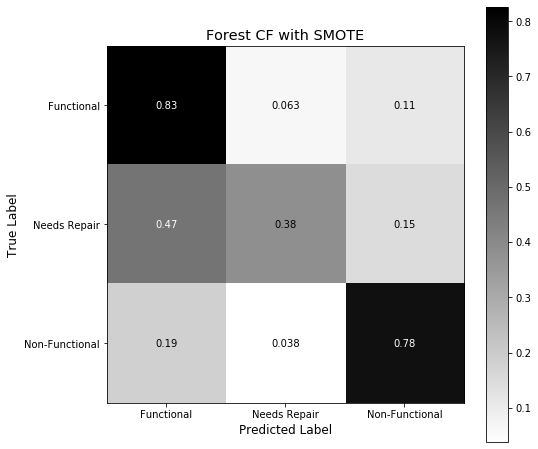

In [6]:
y_pred = forest_pipeline_SMOTE.predict(xtest[features])

plot_pretty_cf(forest_pipeline_SMOTE, xtest[features], ytest, cmap='binary', normalize='true', title='Forest CF with SMOTE')

In [7]:
Our next step was to try out different parameters to see if we could tune our model and improve it. 

SyntaxError: invalid syntax (<ipython-input-7-fe7ec3b8dd24>, line 1)